# CosmoDC realizations
## Dependencies

In [54]:
import numpy as np
import pandas as pd
import random
import scipy
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

In [55]:
import GCRCatalogs
from GCR import GCRQuery

## Data
Load flexzboost the catalog

In [56]:
%%time
cat = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small_with_photozs_flexzboost_v1")
#cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small_with_photozs_v1')
zgrid = cat.photoz_pdf_bin_centers

CPU times: user 252 ms, sys: 24.9 ms, total: 277 ms
Wall time: 2.03 s


In [57]:
healpix_pixels = cat.get_catalog_info()['catalogs'][1]['healpix_pixels']
healpix_pixels

[9559,
 9686,
 9687,
 9814,
 9815,
 9816,
 9942,
 9943,
 10070,
 10071,
 10072,
 10198,
 10199,
 10200,
 10326,
 10327,
 10450]

In [58]:
cat.get_quantities(['ID', 'mag_i_photoz','redshift'],
                   #filters=basic_cuts,
                   native_filters=["healpix_pixel==9814"])

{'ID': array([7937500000, 7937500001, 7937500002, ..., 7958384091, 7958384468,
        7958384878]),
 'mag_i_photoz': array([13.838232, 15.965593, 16.637669, ..., 99.      , 28.156704,
        29.103323], dtype=float32),
 'redshift': array([0.0191445 , 0.01907185, 0.0188237 , ..., 2.94593376, 3.01703267,
        2.94418216])}

In [59]:
basic_cuts = [GCRQuery('photoz_mask==1')]#, #GCRQuery('mag_i_photoz<24.1')]
#basic_cuts = [GCRQuery('mag_i_photoz<24.1')]

In [60]:
#pixels_pzs = {}
for i, pixel in enumerate(healpix_pixels):
    pixel_name = 'healpix_pixel=={}'.format(pixel)
    print(i, pixel_name)
    spec_cat = cat.get_quantities(['mag_i_photoz','redshift'],
                               filters=basic_cuts,
                               native_filters=[pixel_name])

    photo_cat = cat.get_quantities(['photoz_pdf','photoz_mode'],
                               native_filters=[pixel_name])
    
    spec_z = spec_cat['redshift']
    spec_mags = spec_cat['mag_i_photoz']

    magcut = 24.1 #23.6
    brightmask = (spec_mags<magcut)
    pzdict = {'specz':spec_z,
              'zmode':photo_cat['photoz_mode'],
              'pdf':list(photo_cat['photoz_pdf']),
              'mag_i_photoz':spec_mags}
    pzdict = pd.DataFrame(pzdict)
    pzdict = pzdict[brightmask]
    
    if i==0:
        total_pzdict = pzdict
    else:
        total_pzdict = pd.concat([total_pzdict, pzdict])
    print(len(total_pzdict))

0 healpix_pixel==9559
253619
1 healpix_pixel==9686
495339
2 healpix_pixel==9687
748631
3 healpix_pixel==9814
997748
4 healpix_pixel==9815
1242843
5 healpix_pixel==9816
1495854
6 healpix_pixel==9942
1742037
7 healpix_pixel==9943
1982253
8 healpix_pixel==10070
2222988
9 healpix_pixel==10071
2463313
10 healpix_pixel==10072
2696853
11 healpix_pixel==10198
2929083
12 healpix_pixel==10199
3179939
13 healpix_pixel==10200
3419815
14 healpix_pixel==10326
3666088
15 healpix_pixel==10327
3904863
16 healpix_pixel==10450
4139767


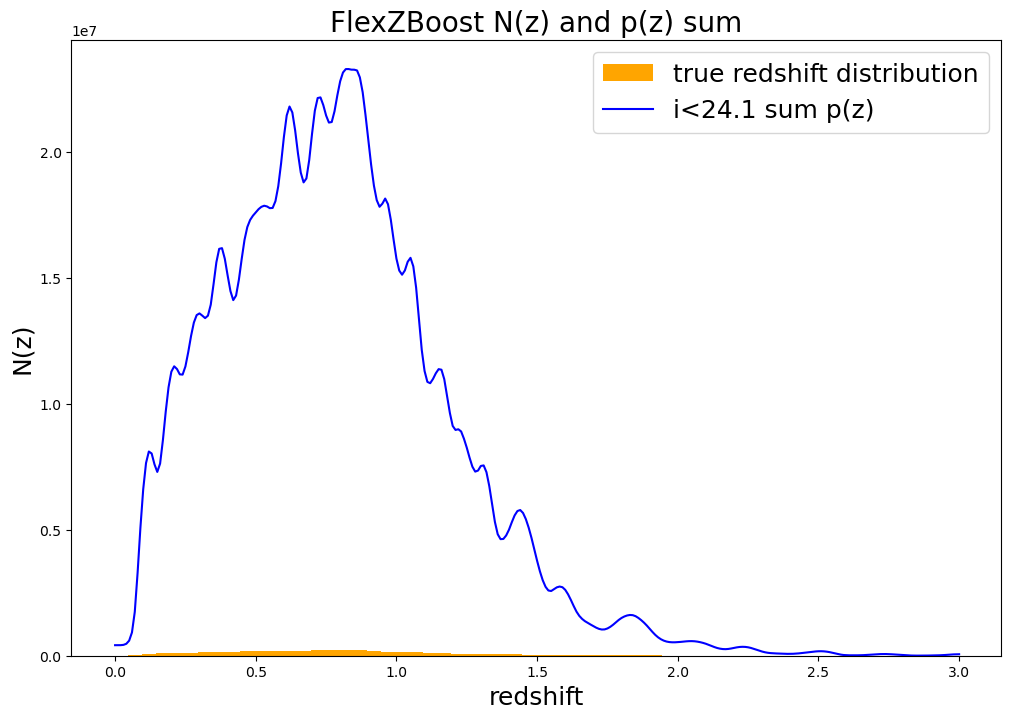

In [61]:
fig = plt.figure(figsize=(12,8))
nzsum = np.sum(total_pzdict['pdf'])
szbins = np.arange(-0.005,3.005,0.05)
plt.hist(total_pzdict['specz'],bins=szbins,color='orange',label='true redshift distribution')
plt.plot(zgrid,5*nzsum,c='b',label=f"i<{magcut} sum p(z)")
plt.xlabel("redshift",fontsize=18)
plt.ylabel("N(z)",fontsize=18)
plt.title("FlexZBoost N(z) and p(z) sum",fontsize=20)
plt.legend(loc = 'upper right',fontsize=18);

## Make Sources

In [126]:
sources_cuts = [[0.0, 0.35],
               [0.35, 0.537],
               [0.537, 0.712],
               [0.712, 0.96],
               [0.96, 3.0]]
sources_grids = [[0.0, 0.7],
                 [0.0, 1.0],
                 [0.3, 1.3],
                 [0.5, 1.5],
                 [0.5, 3.0]]

lenses_cuts = [[0.2, 0.4],
               [0.4, 0.6],
               [0.6, 0.9],
               [0.8, 1.0],
               [1.0, 1.2]]
lenses_grids = [[0.0, 0.6],
                [0.0, 1.0],
                [0.3, 1.0],
                [0.5, 1.3],
                [0.7, 1.5]]

def make_tomo_bins(total_pzdict, cuts, grids,
                   mode='lens', normalize=False, 
                  n_samples=1_000):
    for i in np.arange(len(cuts)):
        print(i)
        cut = cuts[i]
        grid = grids[i]
        tomocut = ((total_pzdict['zmode']>cut[0]) & (total_pzdict['zmode']<=cut[1]))
        photo_pdf = np.array(total_pzdict['pdf'][tomocut])
        print("Make fiducial photo-z")
        photo_fid = np.sum(photo_pdf)
        if normalize:
            photo_norms = np.array([np.sum(pdf) for pdf in photo_pdf])
            photo_pdf = photo_pdf/photo_norms

        print("Generate photo-z dists")
        photo_cdf = np.array([np.cumsum(pdf) for pdf in photo_pdf])

        print("Generate cdf interpolators")
        photo_cdf_i = np.array([interp1d(cdf, zgrid, fill_value="extrapolate") for cdf in photo_cdf])

        print("Generate samples from interpolators")
        rs = np.array([np.random.uniform() for i in np.arange(n_samples)])
        photo_samples = np.array([cdf(rs) for cdf in photo_cdf_i])

        print("Make histograms out of samples")
        zbins = np.linspace(grid[0],grid[1], 20)
        znodes = 0.5*(zbins[1:]+zbins[:-1])
        photo_hists = np.array([np.histogram(samples, bins=zbins, density=False)[0] for samples in photo_samples.T])
        if normalize:
            photo_hists_norms = np.array([np.sum(hist) for hist in photo_hists])
            photo_hists = photo_hists.T/photo_hists_norms
        else:
            photo_hists = photo_hists.T

        print("Generate spectrographic dists")
        spec_zbins = zgrid
        spec_znodes = 0.5*(zgrid[1:]+zgrid[:-1])
        spec = total_pzdict['specz'][tomocut]
        spec_hist = np.histogram(spec, bins=spec_zbins, density=False)[0]
        if normalize:
            spec_hist = spec_hist/np.sum(spec_hist)
    
        file_name = './cut_photo_cats/{}_{}'.format(mode, i)
        np.savez(file_name,
                 zgrid=zbins,
                 znodes=znodes,
                 spec_zgrid=spec_zbins,
                 spec_znodes=spec_znodes,
                 photo_hists=photo_hists,
                 photo_fid=photo_fid,
                 spec_hist=spec_hist)
   

In [127]:
make_tomo_bins(total_pzdict, sources_cuts, spec_sources_cuts, mode='source')

0
Make fiducial photo-z
Generate photo-z dists
Generate cdf interpolators
Generate samples from interpolators
Make histograms out of samples
Generate spectrographic dists
1
Make fiducial photo-z
Generate photo-z dists
Generate cdf interpolators
Generate samples from interpolators
Make histograms out of samples
Generate spectrographic dists
2
Make fiducial photo-z
Generate photo-z dists
Generate cdf interpolators
Generate samples from interpolators
Make histograms out of samples
Generate spectrographic dists
3
Make fiducial photo-z
Generate photo-z dists
Generate cdf interpolators
Generate samples from interpolators
Make histograms out of samples
Generate spectrographic dists
4
Make fiducial photo-z
Generate photo-z dists
Generate cdf interpolators
Generate samples from interpolators
Make histograms out of samples
Generate spectrographic dists


In [128]:
source_0 = np.load('./cut_photo_cats/source_0.npz', allow_pickle=True)
source_1 = np.load('./cut_photo_cats/source_1.npz', allow_pickle=True)
source_2 = np.load('./cut_photo_cats/source_2.npz', allow_pickle=True)
source_3 = np.load('./cut_photo_cats/source_3.npz', allow_pickle=True)
source_4 = np.load('./cut_photo_cats/source_4.npz', allow_pickle=True)

sources = {'source_0': source_0,
          'source_1': source_1,
          'source_2': source_2,
          'source_3': source_3,
          'source_4': source_4}

3.6842106086643143
5.26315801237759
5.26315801237759
5.26315801237759
13.157895030943976


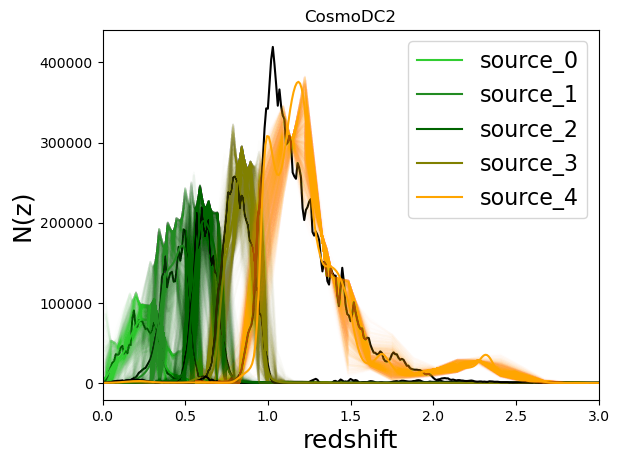

In [138]:
#fig = plt.figure(figsize=(15,8))
colors = ['limegreen', 'forestgreen', 'darkgreen', 'olive', 'orange']
for i, key in enumerate(list(sources.keys())):
    tomo = sources[key]
    photo_dz = np.mean(np.diff(tomo['zgrid']))
    spec_dz = np.mean(np.diff(tomo['spec_zgrid']))
    alpha = photo_dz/spec_dz
    print(alpha)
    plt.plot(tomo['spec_znodes'], alpha*tomo['spec_hist'], 'k-')
    plt.plot(tomo['znodes'], tomo['photo_hists'], '-', color=colors[i], alpha=0.01)
    plt.plot(tomo['spec_zgrid'], alpha*tomo['photo_fid'], '-', color=colors[i], label=key)

#nzsum = np.sum(fz_df['pdf'])
#plt.plot(zgrid,nzsum,c='b',label=f"i<{magcut} sum p(z)")

plt.xlim([0.0, 3.0])
plt.title("CosmoDC2")
plt.xlabel("redshift",fontsize=18)
plt.ylabel("N(z)",fontsize=18)
plt.legend(loc = 'upper right',fontsize=16);
plt.show()

In [130]:
make_tomo_bins(total_pzdict, lenses_cuts, spec_lenses_cuts, mode='lens')

0
Make fiducial photo-z
Generate photo-z dists
Generate cdf interpolators
Generate samples from interpolators
Make histograms out of samples
Generate spectrographic dists
1
Make fiducial photo-z
Generate photo-z dists
Generate cdf interpolators
Generate samples from interpolators
Make histograms out of samples
Generate spectrographic dists
2
Make fiducial photo-z
Generate photo-z dists
Generate cdf interpolators
Generate samples from interpolators
Make histograms out of samples
Generate spectrographic dists
3
Make fiducial photo-z
Generate photo-z dists
Generate cdf interpolators
Generate samples from interpolators
Make histograms out of samples
Generate spectrographic dists
4
Make fiducial photo-z
Generate photo-z dists
Generate cdf interpolators
Generate samples from interpolators
Make histograms out of samples
Generate spectrographic dists


In [131]:
lens_0 = np.load('./cut_photo_cats/lens_0.npz', allow_pickle=True)
lens_1 = np.load('./cut_photo_cats/lens_1.npz', allow_pickle=True)
lens_2 = np.load('./cut_photo_cats/lens_2.npz', allow_pickle=True)
lens_3 = np.load('./cut_photo_cats/lens_3.npz', allow_pickle=True)
lens_4 = np.load('./cut_photo_cats/lens_4.npz', allow_pickle=True)

lenses = {'lens_0': lens_0,
          'lens_1': lens_1,
          'lens_2': lens_2,
          'lens_3': lens_3,
          'lens_4': lens_4}

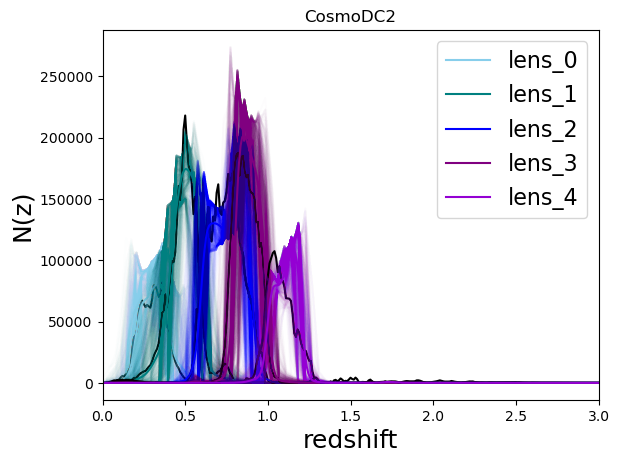

In [139]:
#fig = plt.figure(figsize=(15,8))
colors = ['skyblue', 'teal', 'blue', 'purple', 'darkviolet']
for i, key in enumerate(list(lenses.keys())):
    tomo = lenses[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(zgrid))
    alpha = photo_dz/spec_dz
    plt.plot(tomo['spec_znodes'], alpha*tomo['spec_hist'], 'k-')
    plt.plot(tomo['znodes'], tomo['photo_hists'], '-', color=colors[i], alpha=0.01)
    plt.plot(tomo['spec_zgrid'], alpha*tomo['photo_fid'], '-', color=colors[i], label=key)

#nzsum = np.sum(fz_df['pdf'])
#plt.plot(zgrid,nzsum,c='b',label=f"i<{magcut} sum p(z)")

plt.xlim([0.0, 3.0])
plt.title("CosmoDC2")
plt.xlabel("redshift",fontsize=18)
plt.ylabel("N(z)",fontsize=18)
plt.legend(loc = 'upper right',fontsize=16);
plt.show()